# Kit Data Science 2021 final project

## 0 - Charger le jeu de données nettoyé depuis les fichiers pickle et passer directement à l'étape 5 !

In [2]:
import requests
from requests import Response
from bs4 import BeautifulSoup
from multiprocessing.pool import ThreadPool as Pool
from pathlib import Path
import pandas as pd
import numpy as np
import re
from geopy import Point
from openpyxl import load_workbook
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import pickle
import os
import seaborn as sns
from sklearn.linear_model import LinearRegression
import random
sns.set_theme()

In [3]:
CACHED_RANKING_PATH = r'./rankings.pkl'

# load rankings dataset from pickle here
if os.path.exists(CACHED_RANKING_PATH):
    with open(CACHED_RANKING_PATH, 'rb') as f:
        rankings_df = pickle.load(f)

In [4]:
CACHED_BOATS_PATH = r'./boats.pkl'

# load boats dataset from pickle here
if os.path.exists(CACHED_BOATS_PATH):
    with open(CACHED_BOATS_PATH, 'rb') as f:
        boats_df = pickle.load(f)

[JUMP TO PART 5](#part-5)

## 1 - Récupération des données de classement de vendeeglobe.org (au format .xlsx)

In [ ]:
# Listing file dates from the selection combo box
BASE_URL = r"https://www.vendeeglobe.org"
rankings_page: Response = requests.get(BASE_URL + "/fr/classement")
soup: BeautifulSoup = BeautifulSoup(rankings_page.content)

In [ ]:
file_time_stamps = {element['value'] for element in soup.find("select", {"class": "form__input m--select onsubmit-rank"}).find_all("option") if element['value']}

# Location for downloading files
excel_file_urls = [f"{BASE_URL}/download-race-data/vendeeglobe_{time_stamp}.xlsx" for time_stamp in file_time_stamps]

# Location to store downloaded files
file_dest = [f"./data/rankings/vendeeglobe_{time_stamp}.xlsx" for time_stamp in file_time_stamps]

In [ ]:
# Multi threaded file download ./data/rankings
def download_and_save_file(url:str, dest:str)->None:
    r = requests.get(url)
    with open(dest, 'wb') as f:
        f.write(r.content)
pool = Pool()
future = pool.starmap(download_and_save_file, [(url, dest) for url, dest in zip(excel_file_urls, file_dest)])

In [ ]:
def dms2dd(s):
    '''Converts string degree mintures direction coordinates to float decimal degree coordinantes'''
    degrees, minutes, direction = re.split('[°\'"]+', s)
    return Point.parse_degrees(float(degrees), float(minutes), 0, direction)

## 2-Nettoyage des données de classement.

In [ ]:
dfs = []

for file in sorted(file_dest):
    file_path = Path(file)
    # Reading data from spreadsheets
    wb = load_workbook(filename=file_path.absolute())
    row_values = lambda row: [cell.value for cell in row]
    values = [row_values(row) for row in wb['fr'].rows]
    df = pd.DataFrame(values)
    
    # Deleting the first 5 header rows
    df.drop(df.index[:5], inplace=True)
    
    #Slicing out the empty columns
    df.drop([df.columns[0]] + list(df.columns[21:]), axis=1, inplace=True)
    
    #Dropping rows with empty values
    df.dropna(inplace=True)
    
    if len(df) > 24:  # skip all the files with a changed format (after the first arrivals)
        
        # Setting the file date as a timestamp column
        df['timestamp'] = pd.to_datetime(file_path.stem[12:], format="%Y%m%d_%H%M%S")

        # Listing and setting all the source file columns
        src_columns = ['rank', 'nat. / sail', 'skipper / crew', 'hour_fr', 'latitude', 
                       'longitude', '30m_heading', '30m_speed', '30m_vmg', '30m_distance',
                       'lr_heading', 'lr_speed', 'lr_vmg', 'lr_distance', '24h_heading', 
                       '24h_speed', '24h_vmg', '24h_distance', 'dtf', 'dtl', 'timestamp']
        
        df.columns = src_columns
        df['rank'] = df['rank'].apply(int)
        # splitting skipper crew column
        df[['skipper', 'crew']] = df['skipper / crew'].str.split('\n', expand=True)
        df.drop('skipper / crew', axis=1, inplace=True)
        
        # Hour column as values
        df['hour_fr'] = df['hour_fr'].str.split('\n').str[0].str.split(' ').str[0]
        
        
        # Splitting nation number column
        df['sail_number'] = df['nat. / sail'].str.strip()
        df.drop('nat. / sail', axis=1, inplace=True)
        
        # Converting coordinates to decimal degrees
        df['latitude'] = df['latitude'].apply(str).apply(dms2dd)
        df['longitude'] = df['longitude'].apply(dms2dd)


        # Heading columns as floats and unit in column name
        heading_columns = [col for col in df.columns if 'heading' in col]
        for col in heading_columns:
            df[col] = df[col].str.split('°').str[0].apply(float)
        df.rename(columns={col: col + "_deg" for col in heading_columns}, inplace=True)

        # Speed columns as floats and unit in column name
        speed_columns = [col for col in df.columns if 'speed' in col or 'vmg' in col]
        for col in speed_columns:
            df[col] = df[col].str.split(' ').str[0].apply(float)
        df.rename(columns={col: col + "_kts" for col in speed_columns}, inplace=True)

        # Distance columns as floats and unit in column name
        distance_columns = [col for col in df.columns if 'distance' in col] + ['dtf', 'dtl']
        for col in distance_columns:
            df[col] = df[col].str.split(' ').str[0].apply(float)
        df.rename(columns={col: col+ "_nm" for col in distance_columns}, inplace=True)

        # Cleaning sail_numbers with a same formating
        sail_number_mapper = {"FR\nFRA 69": "FRA 69", "FRA 09":"FRA 9", "FR\nFRA 02":"FRA 2", "FRA 01": "FRA 1"}
        df["sail_number"] = df["sail_number"].map(sail_number_mapper).fillna(df["sail_number"])
        # Final dataframe column order
        tgt_columns = ['timestamp', 'rank', 
                       'sail_number', 
                       'skipper', 'crew',  'hour_fr', 
                       'latitude', 'longitude', 
                       '30m_heading_deg', '30m_speed_kts', '30m_vmg_kts', '30m_distance_nm', 
                       'lr_heading_deg', 'lr_speed_kts', 'lr_vmg_kts', 'lr_distance_nm', 
                       '24h_heading_deg', '24h_speed_kts', '24h_vmg_kts', '24h_distance_nm', 
                       'dtf_nm', 'dtl_nm',]

        # appending file dataframe (for a faster concat we have no memory constraints)
        dfs.append(df[tgt_columns])


In [ ]:
# Concatenad dataframe and pickle to disk for faster access
rankings_df = pd.concat(dfs)

In [ ]:
with open(CACHED_RANKING_PATH, 'wb') as f:
    pickle.dump(rankings_df, f)

In [ ]:
rankings_df.head(10)

## 3 - Récupération des caractéristiques techniques des voiliers

In [ ]:
skippers_page = requests.get(BASE_URL + '/en/skippers')
soup2 = BeautifulSoup(skippers_page.content)
skipper_urls = [ BASE_URL + e['href'] for e in soup2.find_all('a', {"class": "skippers-grid__item"})]
boats_info = []
for url in skipper_urls:
    skipper_page = requests.get(url)
    soup3 = BeautifulSoup(skipper_page.content)
    specs = { e.text.split(':')[0].strip().lower().replace(' ', '_'): e.text.split(':')[-1].strip() for e in soup3.find_all('li', {"class": "skipper-boat-list-specs-list__item"})}
    specs["skipper"] = soup3.find("span", {"class": "breadcrumb__item is-current"}).text.strip().lower().title().replace("  ", ' ')
    boats_info.append(specs)

## 4 - Nettoyage des données de caractéristiques techniques des voiliers

In [ ]:
boats_df = pd.DataFrame(boats_info)

# Cleaning skipper name data on the boats dataframe (for joins with rankings data frame)
map_df = pd.DataFrame()
map_df["ranks_skipper"] = pd.Series(rankings_df.skipper.sort_values(ignore_index=True).unique())
map_df['boats_skipper'] = boats_df.skipper.sort_values(ignore_index=True)
map_df['compare'] = map_df["boats_skipper"] == map_df["ranks_skipper"]
skipper_mapper = {row[1]: row[0] for _, row in map_df[(map_df["compare"] == False)].iterrows()}
boats_df["skipper"] = boats_df["skipper"].map(skipper_mapper).fillna(boats_df["skipper"])

# Converting launch_date
boats_df['launch_date'] = pd.to_datetime(boats_df['launch_date'], format="%d %B %Y")

# Converting length, area and weight columns to floats
length_columns = ['length', 'beam', 'draught', 'mast_height']
for col in length_columns:
    boats_df[col] = boats_df[col].str.replace("m| m", '', regex=True).str.replace(',', '.').apply(float)
boats_df.rename(columns={col: col + "_m" for col in length_columns}, inplace=True)

boats_df["weight"] = boats_df["weight"].str.replace(" tonnes|t| t", '', regex=True).str.replace(',', '.', regex=True).replace({"NC": np.nan, "nc": np.nan}).apply(float)
boats_df.rename(columns={"weight": "weight_t"}, inplace=True)

area_columns = ['upwind_sail_area', 'downwind_sail_area']
for col in area_columns:
    boats_df[col] = boats_df[col].str.replace("m2| m2|m²| m²", '', regex=True).str.replace(',', '.', regex=True).apply(float)
boats_df.rename(columns={col: col + "_m2" for col in area_columns}, inplace=True)

# Delete the sail_number data (badly formatted)
boats_df.drop("sail_number", axis=1, inplace=True)

#Adding a foils column based on number_of_drifts yes - no
boats_df['foils'] = boats_df['number_of_drifts'].map({'foils': True, '2': False, '2 asymétriques': False, 'foiler': True})

In [ ]:
with open(CACHED_BOATS_PATH, 'wb') as f:
    pickle.dump(boats_df, f)

In [ ]:
boats_df.head(10)

## 5 - Jointure entre les classements et les caractéristiques techniques. <a id='part-5'></a>

In [5]:
join_df = pd.merge(rankings_df, boats_df, how='left', left_on='skipper', right_on='skipper')
join_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13703 entries, 0 to 13702
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   timestamp              13703 non-null  datetime64[ns]
 1   rank                   13703 non-null  int64         
 2   sail_number            13703 non-null  object        
 3   skipper                13703 non-null  object        
 4   crew                   13703 non-null  object        
 5   hour_fr                13703 non-null  object        
 6   latitude               13703 non-null  float64       
 7   longitude              13703 non-null  float64       
 8   30m_heading_deg        13703 non-null  float64       
 9   30m_speed_kts          13703 non-null  float64       
 10  30m_vmg_kts            13703 non-null  float64       
 11  30m_distance_nm        13703 non-null  float64       
 12  lr_heading_deg         13703 non-null  float64       
 13  l

In [6]:
join_df.head()

timestamp  rank sail_number         skipper  \
0 2020-11-08 14:00:00     1      FRA 18    Louis Burton   
1 2020-11-08 14:00:00     2      MON 10  Boris Herrmann   
2 2020-11-08 14:00:00     3       FRA 8   Jérémie Beyou   
3 2020-11-08 14:00:00     4      FRA 59   Thomas Ruyant   
4 2020-11-08 14:00:00     5      FRA 53    Maxime Sorel   

                                 crew hour_fr   latitude  longitude  \
0                     Bureau Vallée 2   15:30  46.407667  -1.841333   
1  Seaexplorer - Yacht Club De Monaco   15:31  46.405667  -1.830333   
2                              Charal   15:30  46.415167  -1.833167   
3                           LinkedOut   15:30  46.411833  -1.828000   
4                     V And B Mayenne   15:30  46.409833  -1.826000   

   30m_heading_deg  30m_speed_kts  ...  length_m  beam_m  draught_m  weight_t  \
0            241.0           17.7  ...     18.28    5.80        4.5       7.6   
1            241.0           11.1  ...     18.28    5.70        4.5       7.6   
2            244.0           15.5  ...     18.28    5.85        4.5       8.0   
3            244.0           13.2  ...     18.28    5.85        4.5       8.0   
4            246.0           10.9  ...     18.28    5.50        4.5       7.7   

   number_of_drifts  mast_height_m   keel_blade  upwind_sail_area_m2  \
0             foils           28.0        acier                300.0   
1             foils           29.0        acier                290.0   
2             foils           29.0        acier                320.0   
3             foils           29.0  acier forgé                350.0   
4                 2           29.0        acier                365.0   

   downwind_sail_area_m2  foils  
0                  600.0   True  
1                  490.0   True  
2                  600.0   True  
3                  560.0   True  
4                  700.0  False  

[5 rows x 36 columns]

## 6 - Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

In [7]:
# plotting the avg vmg vs rank 
avg_vmg_df = join_df[['rank', '30m_vmg_kts', '24h_vmg_kts', 'lr_vmg_kts']].groupby(['rank']).mean()

# drop outliers
avg_vmg_df = avg_vmg_df[avg_vmg_df['24h_vmg_kts'] > 0]

X = avg_vmg_df['24h_vmg_kts'].values
Y = avg_vmg_df.index.values
model = LinearRegression(fit_intercept=True).fit(X.reshape(-1, 1), Y)
fig = figure(figsize=(10, 8), dpi=100)

ax1 = plt.plot(X, Y, '+', color='royalblue', label="Observations")

ax2 = plt.plot(X, model.predict(X.reshape(-1, 1)), color='royalblue', label="Model Predictions")

fig.suptitle('Linear regression: Race rank explained by mean 24h_vmg measures in kts', fontsize=16)
plt.xlabel('mean 24 vmg in kts', fontsize=16)
plt.ylabel('Rank', fontsize=16)

# linear regression rank explained by average vmg (uncentered)

sns.lineplot(x=X, y=model.predict(X.reshape(-1, 1)))
plt.show()

## 7 - Impact de la présence d'un foil sur le classement et la vitesse des voiliers.

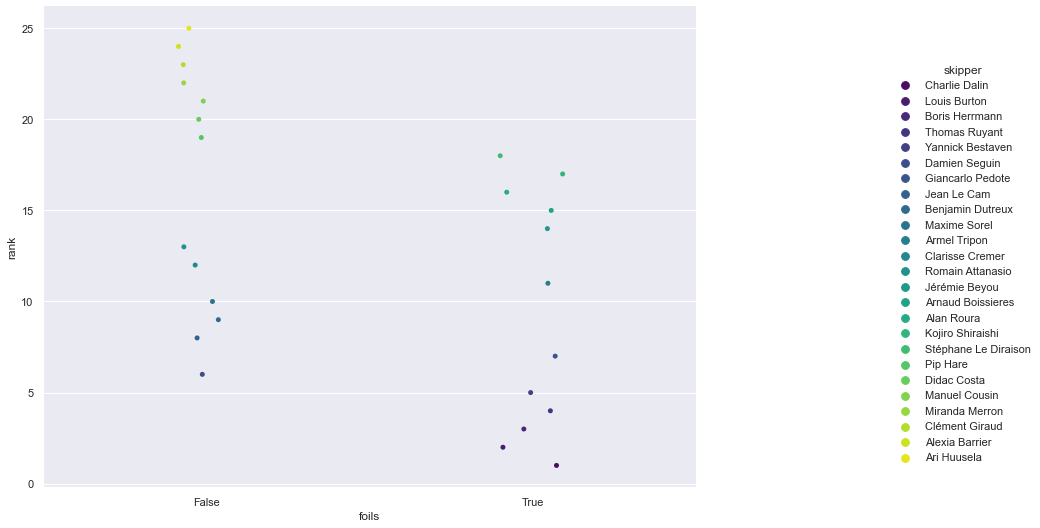

In [8]:
# Foiling in the the final ranking by skipper
cat = sns.catplot(y="rank", x="foils", data=join_df[join_df['timestamp'] == join_df['timestamp'].max()], hue='skipper',palette="viridis",)
cat.fig.set_size_inches(16, 8)
plt.show()

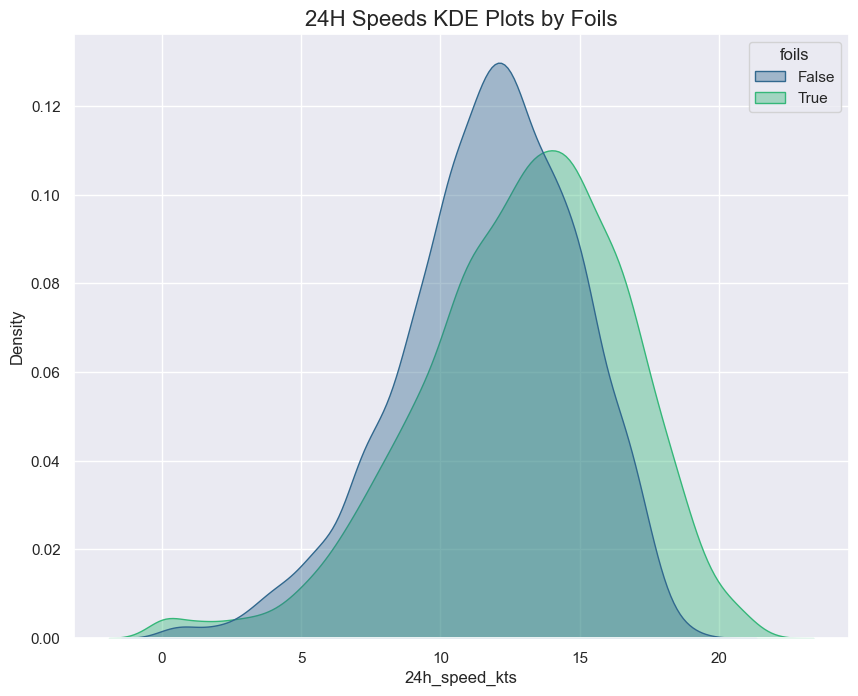

In [9]:
# Speed measure by foiling
fig = figure(figsize=(10, 8), dpi=100), 
sns.kdeplot(x="24h_speed_kts", hue="foils", data=join_df, fill=True, common_norm=False, alpha=0.4, palette="viridis",).set_title("24H Speeds KDE Plots by Foils", fontsize=16)
plt.show()

Text(0.5, 1.0, '24H Speeds Box Plots')

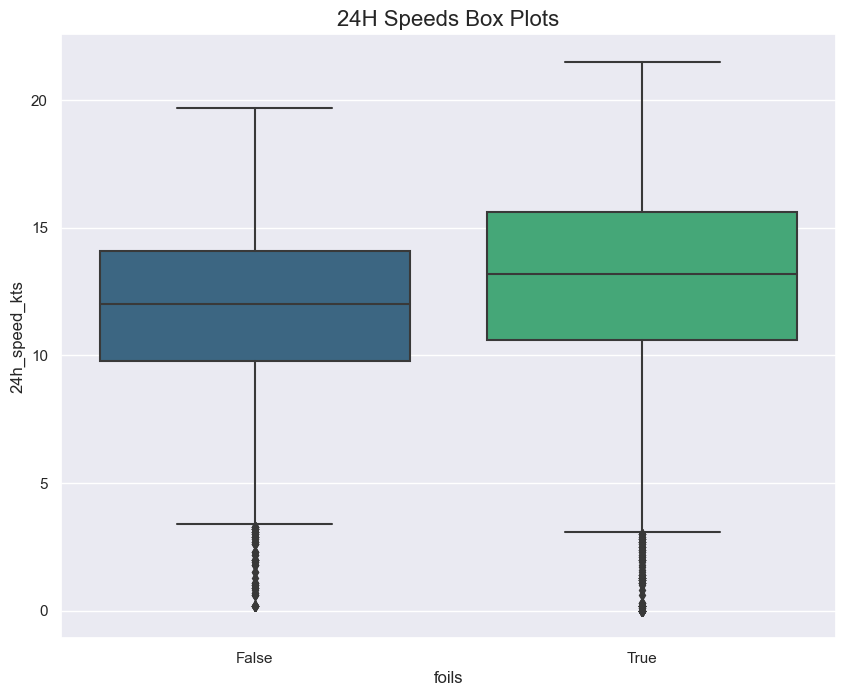

In [10]:
# Speed measure by foiling
fig = figure(figsize=(10, 8), dpi=100)
sns.boxplot(x="foils", y="24h_speed_kts", palette="viridis", data=join_df).set_title("24H Speeds Box Plots", fontsize=16)

## 8 - Visualisation de la distance parcourue par voilier.

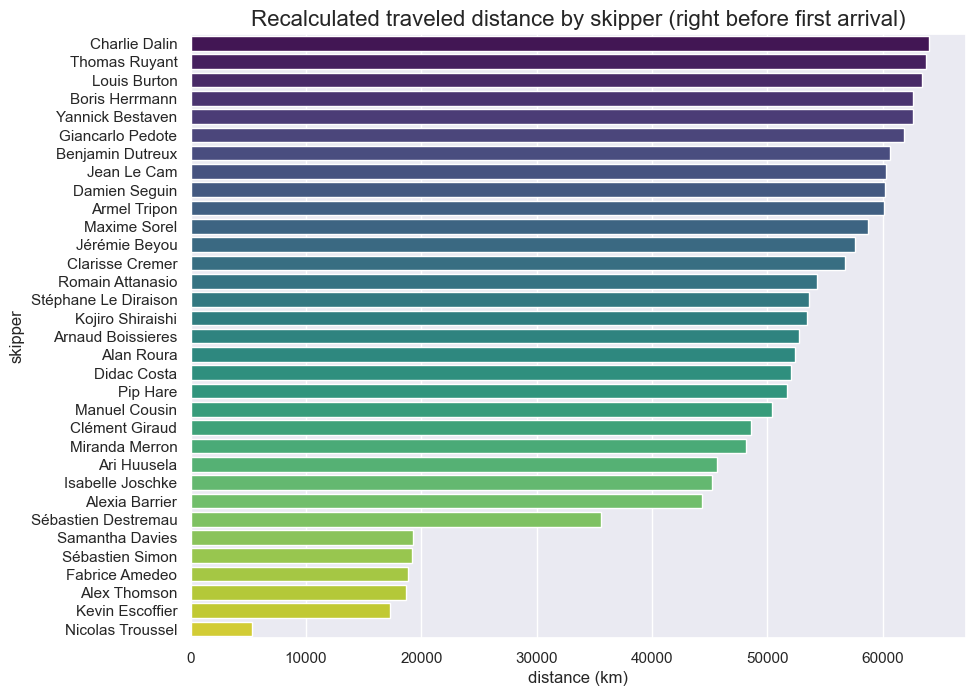

In [11]:
from shapely.geometry import LineString
from shapely.ops import transform
import pyproj
from functools import partial

distances = []
for i, skipper in enumerate(join_df['skipper'].unique()):
    locs = [c for _, c in join_df[join_df['skipper'] == skipper][['latitude', 'longitude']].iterrows()]
    lgts = [c[1] for c in locs]
    max_lgt = max(lgts)
    idx_max = lgts.index(max_lgt) if abs(max_lgt - 180) < 5 else len(lgts)

    p1 = locs[:idx_max + 1]
    p2 = [(c[0], 360 + c[1]  ) for c in locs[idx_max + 1:]]

    ls = LineString(p1+p2)

    project = partial(
        pyproj.transform,
        pyproj.Proj('EPSG:4326'),
        pyproj.Proj('EPSG:32633'))

    distances.append(round(transform(project, ls).length /1000))
distances
dist_df = pd.DataFrame()
dist_df['skipper'] = join_df['skipper'].unique()
dist_df['distance'] = distances
dist_df = dist_df.sort_values('distance', ascending=False)
fig = figure(figsize=(10, 8), dpi=100)
dist_by_skipper = sns.barplot(x='distance',y='skipper', data=dist_df,  palette="viridis", orient='h')
dist_by_skipper.set(xlabel='distance (km)')
dist_by_skipper.set_title("Recalculated traveled distance by skipper (right before first arrival)", fontsize=16)
plt.show()

## 9 - Cartes avec les routes d'un ou plusieurs voiliers.

In [12]:
from ipyleaflet import Map, basemaps, Marker, Polyline, projections, LayersControl, AwesomeIcon
import ipywidgets as widgets 
center = (26.7, 161.9)
zoom = 2
m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)

# split the line plot in 2 at 0 lat
les_sables_cd = (46.40, -1.84)

anchor_icon = AwesomeIcon(
    name='anchor',
    marker_color='red',
    icon_color='black',
    spin=False
)

m.add_layer(Marker(icon=anchor_icon, location=les_sables_cd, title="Départ Les Sables-d'Olonne", name="Départ Les Sables-d'Olonne"))
m.add_layer(Marker(icon=anchor_icon, location=(les_sables_cd[0], les_sables_cd[1] + 360), title="Arrivée Les Sables-d'Olonne", name="Arrivée Les Sables-d'Olonne"))

# colors = [matplotlib.colors.to_hex(c) for c in cm.rainbow(np.linspace(0, 1, len(join_df['skipper'].unique())), alpha=0.5)]
colors = ['white', 'red', 'darkred', 'orange', 'beige', 'green', 'darkgreen', 'lightgreen', 'blue', 'darkblue', 'lightblue', 'purple', 'pink', 'cadetblue', 'white', 'gray', 'lightgray', 'black']

skipper_crew = { s[0]: s[1]  for _, s in join_df[['skipper', 'crew']].drop_duplicates().iterrows()}
report_timestamps = list(join_df['timestamp'].unique())

select_skipper = widgets.SelectMultiple(
    options=tuple(skipper_crew.keys()),
    value=tuple(skipper_crew.keys()),
    description='Skippers',
    disabled=False
)

select_ranking_dt = widgets.Dropdown(
    options=[(pd.to_datetime(t), t) for t in report_timestamps],
    value=report_timestamps[-1],
    description='Ranking dt',
)


def update_plots(skippers, ts):
    filtered_join_df = join_df[join_df['timestamp'] <= ts]
    route_layers = [l for l in m.layers if isinstance(l, Polyline) or 'location' in l.name]
    for l in route_layers:
        m.remove_layer(l)
    for skipper in skippers:
        color = random.choice(colors)
        plots = filtered_join_df.loc[filtered_join_df['skipper'] == skipper,['latitude', 'longitude']]
        locs = [(row[0], row[1]) for _, row in plots.iterrows()]
        lgts = [c[1] for c in locs]
        max_lgt = max(lgts)
        idx_max = lgts.index(max_lgt) if abs(max_lgt - 180) < 5 else len(lgts)
        p1 = locs[:idx_max + 1]
        p2 = [(c[0], 360 + c[1]  ) for c in locs[idx_max + 1:]]
        m.add_layer(Polyline(locations=p1+p2, color=color, fill=False, name=skipper + " route", opacity=1, weight=1))
        ship_icon = AwesomeIcon(name='ship', marker_color=color, icon_color='black' if not color == 'black' else 'white', spin=False)
        m.add_layer(Marker(icon=ship_icon, location=(p1+p2)[-1], title=skipper + " - "+ skipper_crew[skipper], name=skipper + " location"))


display(widgets.Label(value="Select one or more skippers and a ranking date to plot the raveled route on the world map."))
widgets.interact(update_plots, skippers=select_skipper, ts=select_ranking_dt)

m.layout.height = '800px'
m.layout.width = '90%'

m

Label(value='Select one or more skippers and a ranking date to plot the raveled route on the world map.')

interactive(children=(SelectMultiple(description='Skippers', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

Map(center=[26.7, 161.9], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

## 10 - Analyses de séries temporelles.

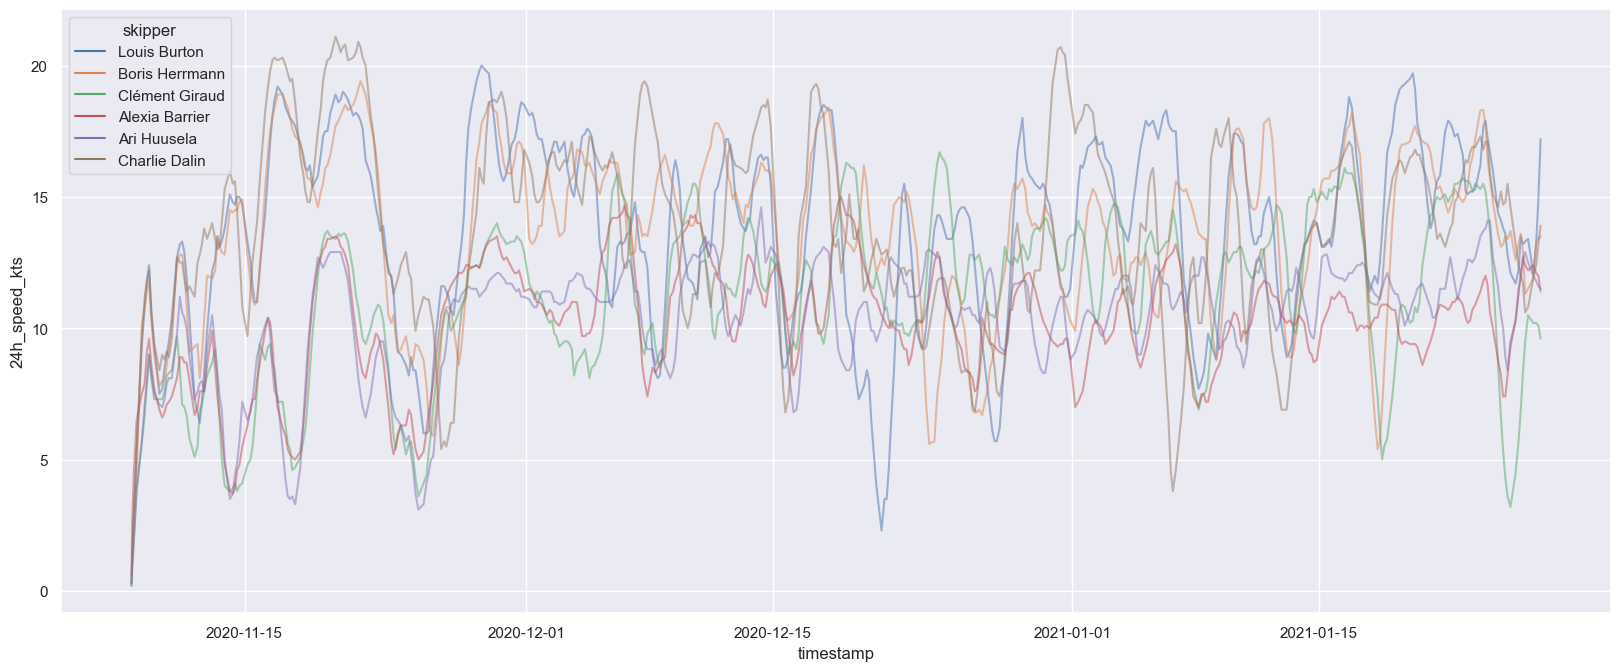

In [13]:
# let's look at 24h speeds of the top 3 and last 3 of the race
last_ranking = join_df[join_df['timestamp'] == join_df['timestamp'].max()]
top_3_last_3_ranks = last_ranking['rank'].nsmallest(3).tolist() + last_ranking['rank'].nlargest(3).tolist()
top_3_last_3_skippers = last_ranking[last_ranking['rank'].isin(top_3_last_3_ranks)]["skipper"]
fig = figure(figsize=(20, 8), dpi=100)
sns.lineplot(x='timestamp', y='24h_speed_kts', hue='skipper', alpha=0.5, data=join_df[join_df['skipper'].isin(top_3_last_3_skippers)])
plt.show()

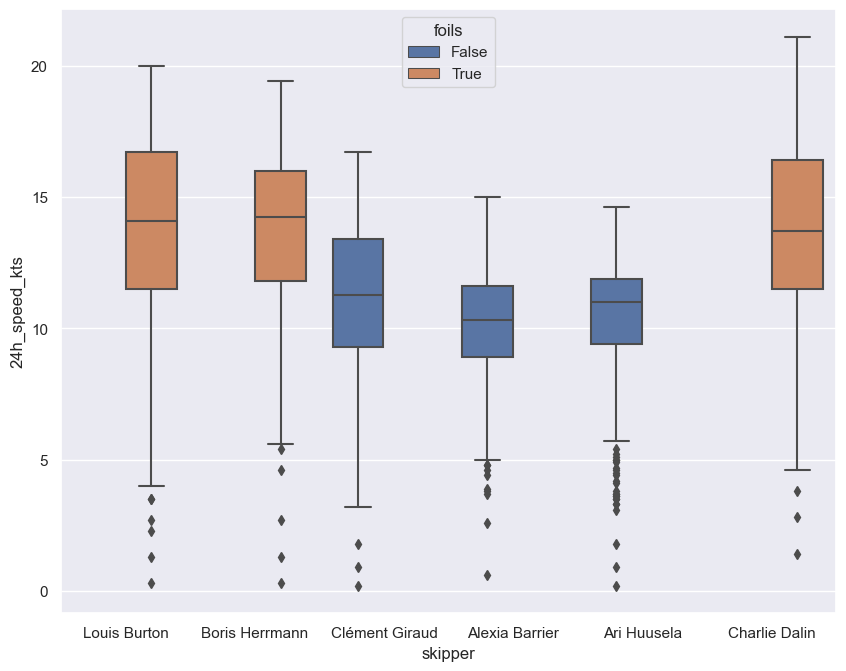

In [14]:
fig = figure(figsize=(10, 8), dpi=100)
sns.boxplot(y='24h_speed_kts', x='skipper',  hue='foils', data=join_df[join_df['skipper'].isin(top_3_last_3_skippers)])
plt.show()